# Diabetes Dataset - EDA

## Opening and First look

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('../diabetes_unclean.csv')

In [3]:
dataset.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26.0,4.5,62.0,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33.0,7.1,46.0,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [4]:
print(dataset.columns.values)

['ID' 'No_Pation' 'Gender' 'AGE' 'Urea' 'Cr' 'HbA1c' 'Chol' 'TG' 'HDL'
 'LDL' 'VLDL' 'BMI' 'CLASS']


## Dataset features
In the dataset we can access the following feature:

- **Gender**: The gender of the individual (e.g., Male, Female).

- **AGE**: The age of the individual in years.

- **Urea**: The level of urea in the blood, indicating kidney function. 

- **Cr**: Creatinine level in the blood, used to assess kidney function.


- **HbA1c**: Hemoglobin A1c percentage, a measure of average blood sugar levels over the past 2-3 months.

- **Chol**: Total cholesterol level in the blood, measured in mg/dL, indicating lipid profile.

- **TG**: Triglycerides level in the blood, measured in mg/dL, another component of the lipid profile.

- **HDL**: High-Density Lipoprotein cholesterol, often referred to as "good cholesterol," measured in mg/dL.

- **LDL**: Low-Density Lipoprotein cholesterol, often referred to as "bad cholesterol," measured in mg/dL.

- **VLDL**: Very Low-Density Lipoprotein cholesterol, another type of "bad cholesterol," measured in mg/dL.

- **BMI**: Body Mass Index, a measure of body fat based on height and weight.

- **CLASS**: The target variable indicating the presence or absence of diabetes (e.g., diabetic or non-diabetic).


In [5]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1009 non-null   int64  
 1   No_Pation  1009 non-null   int64  
 2   Gender     1009 non-null   object 
 3   AGE        1008 non-null   float64
 4   Urea       1008 non-null   float64
 5   Cr         1007 non-null   float64
 6   HbA1c      1006 non-null   float64
 7   Chol       1007 non-null   float64
 8   TG         1007 non-null   float64
 9   HDL        1008 non-null   float64
 10  LDL        1007 non-null   float64
 11  VLDL       1008 non-null   float64
 12  BMI        1009 non-null   float64
 13  CLASS      1009 non-null   object 
dtypes: float64(10), int64(2), object(2)
memory usage: 110.5+ KB


In [6]:
dataset.describe()

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1009.000000,1.009000e+03,1008.000000,1008.000000,1007.000000,1006.000000,1007.000000,1007.000000,1008.000000,1007.000000,1008.000000,1009.000000
mean,339.161546,2.717448e+05,53.620040,5.131094,68.973188,8.284155,4.863873,2.348769,1.204216,2.610119,1.850595,29.589911
std,239.738169,3.365681e+06,8.740975,2.931136,59.813297,2.533576,1.297326,1.397487,0.658158,1.116095,3.649859,4.946246
min,1.000000,1.230000e+02,25.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,127.000000,2.406500e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,296.000000,3.439900e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,548.000000,4.539000e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


# Data Cleaning and Preprocessing
- Backup the original dataset
- Check for Null values
- Conversion to numerical values or one-hot encoding of the 'object' or 'string' types
- Check for outliers 

In [7]:
ds_backup = dataset.copy()
ds_backup.to_csv('diabetes_unclean_backup.csv', index=False)

In [8]:
dataset.isnull().sum()

ID           0
No_Pation    0
Gender       0
AGE          1
Urea         1
Cr           2
HbA1c        3
Chol         2
TG           2
HDL          1
LDL          2
VLDL         1
BMI          0
CLASS        0
dtype: int64

### Null values 
Since the total entries of the dataset are 1009 and the Null values are around the 2% of the dataset it is possible to remove them (no fill required)


In [9]:
dataset.dropna(inplace=True)

### Conversion to numerical values

In [10]:
dataset.dtypes

ID             int64
No_Pation      int64
Gender        object
AGE          float64
Urea         float64
Cr           float64
HbA1c        float64
Chol         float64
TG           float64
HDL          float64
LDL          float64
VLDL         float64
BMI          float64
CLASS         object
dtype: object

Columns to be converted or encoded:
- Gender -> simple encoding [0 = 'M', 1 = 'F']
- Class -> simple encoding [0 = non-positive, 1 = positive]


In [11]:
dataset['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

As there are inconsistencies in the gender column we will perform a 'normalization' of the data and a conversion to numeric value 
```
[0: Male, 1: Female]
```

In [12]:
# Repairing inconcistent values and Encoding of the 'Gender' column
dataset['Gender'] = dataset['Gender'].str.upper().map({'M': 0, 'F': 1})

In [13]:
dataset['CLASS'].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

As we can see there are several unique values with inconsistent syntax, since the possible value of the column `CLASS` are 'Diabetic' or 'Not Diabetic' we will encode it with the following syntax:
```
[Positive to diabetes: 1]
[Negative to diabetes: 0]
```

In [14]:
# Encoding of the 'CLASS' column
# 1st: remove unwanted spaces
dataset['CLASS'] = dataset['CLASS'].str.strip()
# 2nd: raise all values to upper case
dataset['CLASS'] = dataset['CLASS'].str.upper()
# 3rd: make the values consistent (e.g. P means positive as well as Y, instead, N means negative or simply No)
dataset['CLASS'] = dataset['CLASS'].replace({'P': 'Y'})

# check:
# dataset['CLASS'].unique()

# 4th: Encoding of the 'CLASS' column
dataset['CLASS'] = dataset['CLASS'].map({'Y': 1, 'N': 0})

### Unused columns
Some columns are not relevant to predict diabetes. For example, columns like `ID` and `No_Pation` do not provide meaningful information for prediction and can be removed.

In [15]:
# removing unused columns
# backup of the cleaned and encoded dataset
ds_backup = dataset.copy()
ds_backup.to_csv('diabetes_cleaned.csv', index=False)
# removing unused columns
dataset.drop(columns=['ID', 'No_Pation'], inplace=True)


# Outliers

In [16]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,994.0,0.434608,0.495955,0.0,0.00,0.0,1.0,1.00
AGE,994.0,53.605634,8.758101,25.0,51.00,55.0,59.0,79.00
Urea,994.0,5.129520,2.948246,0.5,3.67,4.6,5.7,38.90
Cr,994.0,68.742455,60.087902,6.0,48.00,60.0,73.0,800.00
HbA1c,994.0,8.286378,2.542578,0.9,6.50,8.0,10.2,16.00
Chol,994.0,4.859678,1.299625,0.0,4.00,4.8,5.6,10.30
TG,994.0,2.343471,1.399343,0.3,1.50,2.0,2.9,13.80
HDL,994.0,1.206187,0.662212,0.2,0.90,1.1,1.3,9.90
LDL,994.0,2.610151,1.116133,0.3,1.80,2.5,3.3,9.90
VLDL,994.0,1.859054,3.674106,0.1,0.70,0.9,1.5,35.00


## Outliers detenction
As shown in the table above, the features **‘Urea’, ‘Cr’, ‘TG’, ‘HDL’,** and **‘VLDL’** shows high values of $\sigma$. This suggests the need for further investigation to identify potential outliers, particularly extreme values or data points that may not be consistent with human physiological ranges.

### Features Requiring Attention for Outliers  

The following features exhibit potential outliers based on their maximum values, which significantly deviate from the mean and expected physiological ranges:  

- **Urea**: Maximum value **38.9**, while the normal range is typically **2.5 - 7.5 mmol/L**.  
- **Cr (Creatinine)**: Maximum value **800**, whereas normal levels are **50 - 110 µmol/L**. Extremely high values may indicate renal dysfunction, extreme cases or data entry errors. With a high level of certainty, we can consider values equal to 800 as cases of data clipping
- **TG (Triglycerides)**: Maximum value **13.8**, significantly above the normal range **< 1.7 mmol/L**. Values above **10 mmol/L** are considered critically high or not likely.
- **HDL (High-Density Lipoprotein Cholesterol)**: Maximum value **9.9**, while the normal range is **1.0 - 2.0 mmol/L**.  
- **VLDL (Very Low-Density Lipoprotein Cholesterol)**: Maximum value **35.0**, whereas normal levels are around **0.1 - 1.0 mmol/L**.  

These features should be carefully examined for potential extreme values or measurement errors before proceeding with further analysis.

  *Diclaimer*: The reference values provided are not intended for medical purposes and were obtained through online research. They are not guaranteed to be reliable or representative of the sample in question, as this is not the primary objective of the project.



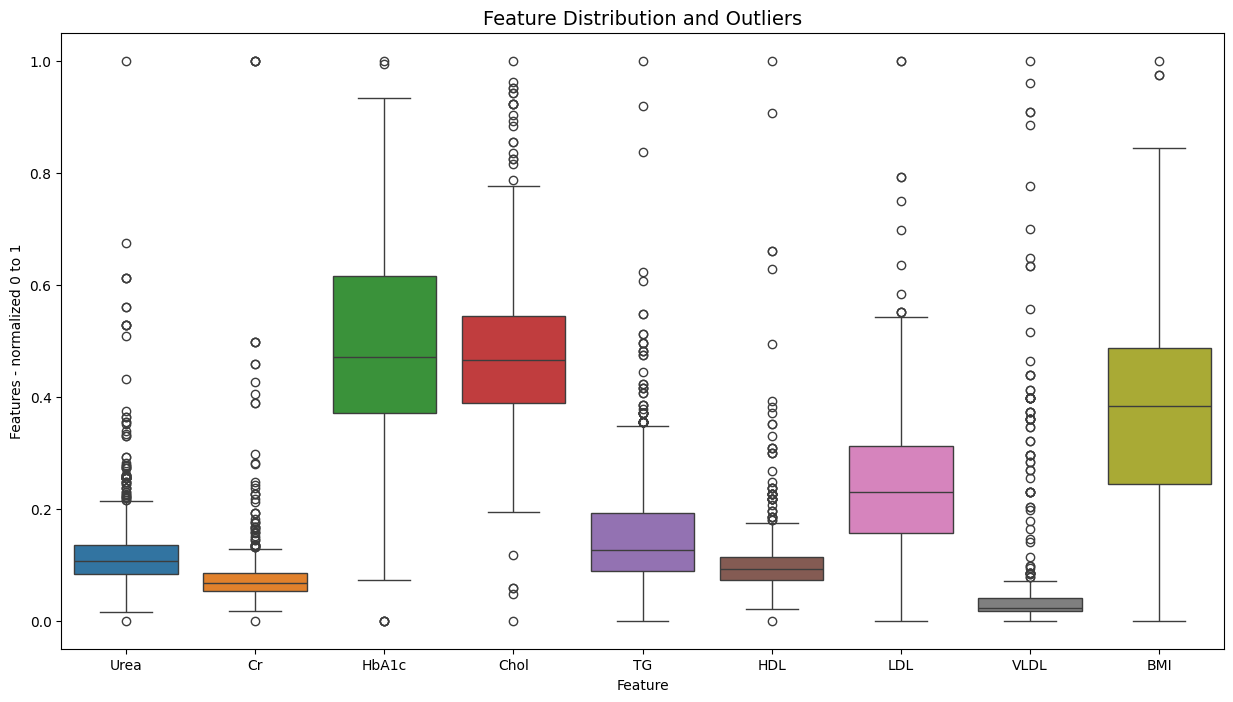

In [ ]:
# Boxplot for outlier detection

# Imposta la dimensione della figura
plt.figure(figsize=(15, 8))

# Crea il boxplot per tutte le colonne numeriche
data = dataset.drop(columns=['Gender', 'AGE', 'CLASS']) # remove categorical columns
sns.boxplot(data=data, orient='v')

# Titolo e labels
plt.title("Feature Distribution and Outliers", fontsize=14)
plt.xlabel("Feature")
plt.ylabel("Features - normalized 0 to 1")

# Mostra il grafico
plt.show()

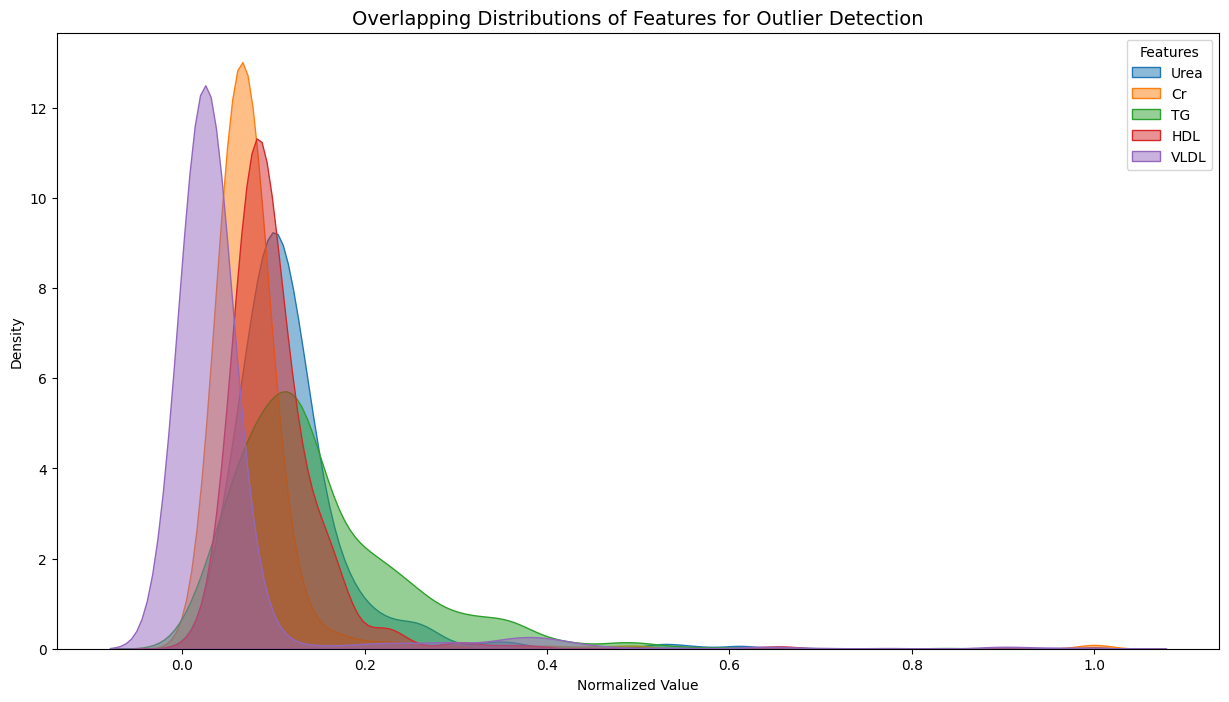

In [25]:
# fig
plt.figure(figsize=(15, 8))

# features to show
features = ['Urea', 'Cr', 'TG', 'HDL', 'VLDL']
# overlapping graph -> more features in the dame plot
for feature in features:
    sns.kdeplot(data=data[feature], label=feature, fill=True, alpha=0.5) 

# Titolo e labels
plt.title("Overlapping Distributions of Features for Outlier Detection", fontsize=14)
plt.xlabel("Normalized Value")
plt.ylabel("Density")
plt.legend(title="Features")

# Mostra il grafico
plt.show()